# Model Training

## 1.1 Import Data and Required Packages

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

### Import the sampled CSV file

In [6]:
dataset = pd.read_csv("..\..\data\Yellow_Taxi_Trip_Sample.csv")

In [7]:
dataset.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,07/27/2017 06:04:13 PM,07/27/2017 06:42:53 PM,1,10.80,1,N,143,138,1,36.0,1.0,0.5,5.00,5.76,0.3,48.56
1,2,07/27/2017 06:30:35 PM,07/27/2017 06:52:03 PM,6,6.53,1,N,231,162,1,21.0,1.0,0.5,3.42,0.00,0.3,26.22
2,2,07/27/2017 06:01:39 PM,07/27/2017 06:24:32 PM,1,3.11,1,N,100,238,2,16.0,1.0,0.5,0.00,0.00,0.3,17.80
3,2,07/27/2017 06:31:48 PM,07/27/2017 06:43:38 PM,1,0.71,1,N,233,230,1,8.5,1.0,0.5,2.06,0.00,0.3,12.36
4,2,07/27/2017 06:10:56 PM,07/27/2017 06:19:01 PM,1,1.35,1,N,186,249,1,7.5,1.0,0.5,2.79,0.00,0.3,12.09


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113118 entries, 0 to 113117
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               113118 non-null  int64  
 1   tpep_pickup_datetime   113118 non-null  object 
 2   tpep_dropoff_datetime  113118 non-null  object 
 3   passenger_count        113118 non-null  int64  
 4   trip_distance          113118 non-null  float64
 5   RatecodeID             113118 non-null  int64  
 6   store_and_fwd_flag     113118 non-null  object 
 7   PULocationID           113118 non-null  int64  
 8   DOLocationID           113118 non-null  int64  
 9   payment_type           113118 non-null  int64  
 10  fare_amount            113118 non-null  float64
 11  extra                  113118 non-null  float64
 12  mta_tax                113118 non-null  float64
 13  tip_amount             113118 non-null  float64
 14  tolls_amount           113118 non-nu

## Data Preparation

- This entails preparing the data before data transformation

This includes:
- Loading the Raw Data - sampled data
- Feature Creation: [Trip Duration, Hour, Day of Week No, Month, Year]
- Dropping the rows that are not needed for modelling
- Drop Features: ['extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount','tpep_pickup_datetime', 'tpep_dropoff_datetime']

In [9]:
dataset.shape

(113118, 17)

**Feature Creation**

In [10]:
#Converting to datetime
dataset["tpep_pickup_datetime"] = pd.to_datetime(dataset["tpep_pickup_datetime"])
dataset["tpep_dropoff_datetime"] = pd.to_datetime(dataset["tpep_dropoff_datetime"])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20600\283500179.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset["tpep_pickup_datetime"] = pd.to_datetime(dataset["tpep_pickup_datetime"])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20600\283500179.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset["tpep_dropoff_datetime"] = pd.to_datetime(dataset["tpep_dropoff_datetime"])


In [11]:
#calculating trip duration(in minutes) using pickup & dropoff times
dataset['trip_duration'] = (dataset["tpep_dropoff_datetime"] - dataset["tpep_pickup_datetime"]).dt.total_seconds() / 60

In [12]:
#Creating the time variables
dataset['pickup_day_no']=dataset['tpep_pickup_datetime'].dt.weekday
dataset['dropoff_day_no']=dataset['tpep_dropoff_datetime'].dt.weekday
dataset['pickup_hour']=dataset['tpep_pickup_datetime'].dt.hour
dataset['dropoff_hour']=dataset['tpep_dropoff_datetime'].dt.hour
dataset['pickup_month']=dataset['tpep_pickup_datetime'].dt.month
dataset['dropoff_month']=dataset['tpep_dropoff_datetime'].dt.month
dataset['pickup_year']=dataset['tpep_pickup_datetime'].dt.year
dataset['dropoff_year']=dataset['tpep_dropoff_datetime'].dt.year

**Filtering the dataset**

In [17]:
#removing records where trip duration, trip distance and total fare amount are recorded as 0
dataset_1 = dataset[(dataset['trip_duration'] !=0) & (dataset['trip_distance']!=0) & (dataset['fare_amount']>0)].reset_index(drop=True)

In [18]:
#Dropping the columns that will NOT be used in the analysis & building the model
#dropping the cplumns
dataset_1.drop(['extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount','tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1,inplace=True)

In [19]:
dataset_1.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'trip_duration', 'pickup_day_no', 'dropoff_day_no',
       'pickup_hour', 'dropoff_hour', 'pickup_month', 'dropoff_month',
       'pickup_year', 'dropoff_year'],
      dtype='object')

In [20]:
dataset_1.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,trip_duration,pickup_day_no,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_year,dropoff_year
0,2,1,10.80,1,N,143,138,1,36.0,38.666667,3,3,18,18,7,7,2017,2017
1,2,6,6.53,1,N,231,162,1,21.0,21.466667,3,3,18,18,7,7,2017,2017
2,2,1,3.11,1,N,100,238,2,16.0,22.883333,3,3,18,18,7,7,2017,2017
3,2,1,0.71,1,N,233,230,1,8.5,11.833333,3,3,18,18,7,7,2017,2017
4,2,1,1.35,1,N,186,249,1,7.5,8.083333,3,3,18,18,7,7,2017,2017


### Preparing X and Y variables

In [21]:
df = dataset_1.copy()

In [22]:
X = df.drop(columns=['fare_amount'],axis=1)

In [23]:
X.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,trip_duration,pickup_day_no,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_year,dropoff_year
0,2,1,10.80,1,N,143,138,1,38.666667,3,3,18,18,7,7,2017,2017
1,2,6,6.53,1,N,231,162,1,21.466667,3,3,18,18,7,7,2017,2017
2,2,1,3.11,1,N,100,238,2,22.883333,3,3,18,18,7,7,2017,2017
3,2,1,0.71,1,N,233,230,1,11.833333,3,3,18,18,7,7,2017,2017
4,2,1,1.35,1,N,186,249,1,8.083333,3,3,18,18,7,7,2017,2017


In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112250 entries, 0 to 112249
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   VendorID            112250 non-null  int64  
 1   passenger_count     112250 non-null  int64  
 2   trip_distance       112250 non-null  float64
 3   RatecodeID          112250 non-null  int64  
 4   store_and_fwd_flag  112250 non-null  object 
 5   PULocationID        112250 non-null  int64  
 6   DOLocationID        112250 non-null  int64  
 7   payment_type        112250 non-null  int64  
 8   trip_duration       112250 non-null  float64
 9   pickup_day_no       112250 non-null  int32  
 10  dropoff_day_no      112250 non-null  int32  
 11  pickup_hour         112250 non-null  int32  
 12  dropoff_hour        112250 non-null  int32  
 13  pickup_month        112250 non-null  int32  
 14  dropoff_month       112250 non-null  int32  
 15  pickup_year         112250 non-nul

In [24]:
y = df['fare_amount']

In [25]:
y

0         36.0
1         21.0
2         16.0
3          8.5
4          7.5
          ... 
112245     9.0
112246     5.5
112247    26.0
112248     8.0
112249    18.5
Name: fare_amount, Length: 112250, dtype: float64

In [27]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [28]:
X = preprocessor.fit_transform(X)

In [29]:
X

array([[ 1.        ,  0.        ,  0.90579638, ...,  0.16838564,
         0.        , -0.00667424],
       [ 1.        ,  0.        ,  0.90579638, ...,  0.16838564,
         0.        , -0.00667424],
       [ 1.        ,  0.        ,  0.90579638, ...,  0.16838564,
         0.        , -0.00667424],
       ...,
       [ 1.        ,  0.        , -1.10400088, ...,  0.16838564,
         0.        , -0.00667424],
       [ 1.        ,  0.        ,  0.90579638, ...,  0.16838564,
         0.        , -0.00667424],
       [ 1.        ,  0.        , -1.10400088, ...,  0.16838564,
         0.        , -0.00667424]])

In [30]:
X.shape

(112250, 18)

In [31]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((89800, 18), (22450, 18))

### Model Evaluation Function

In [32]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [33]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 3.4502
- Mean Absolute Error: 1.9375
- R2 Score: 0.9007
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 3.5788
- Mean Absolute Error: 1.9823
- R2 Score: 0.8977


Lasso
Model performance for Training set
- Root Mean Squared Error: 3.6570
- Mean Absolute Error: 2.1293
- R2 Score: 0.8885
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 3.8707
- Mean Absolute Error: 2.1852
- R2 Score: 0.8804


Ridge
Model performance for Training set
- Root Mean Squared Error: 3.4502
- Mean Absolute Error: 1.9375
- R2 Score: 0.9007
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 3.5788
- Mean Absolute Error: 1.9823
- R2 Score: 0.8977


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 2.7704
- Mean Absolute Error: 1.8775
- R2 Score: 0.9360
-----------------------

### Results

In [34]:
#Creating a dataframe with the list of model names and r2 scores
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,CatBoosting Regressor,0.986560
5,Random Forest Regressor,0.984022
6,XGBRegressor,0.983828
4,Decision Tree,0.971979
3,K-Neighbors Regressor,0.901445
2,Ridge,0.897726
0,Linear Regression,0.897725
1,Lasso,0.880357
8,AdaBoost Regressor,0.646165


From above we can observe that the catboosting regressor model has the best r2 score

### Catboosting Regressor

In [35]:
#Modelling using the Catboostregressor
cat_model = CatBoostRegressor(verbose=False)
cat_model.fit(X_train,y_train)
y_pred = cat_model.predict(X_test)
score = r2_score(y_test,y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 98.66


### Plot y_pred vs y_test

Text(0, 0.5, 'Predicted')

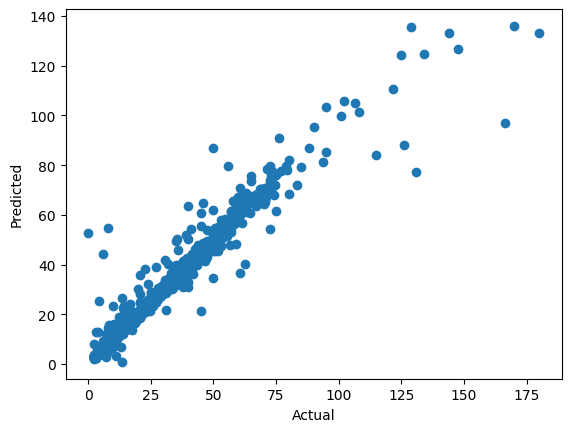

In [36]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

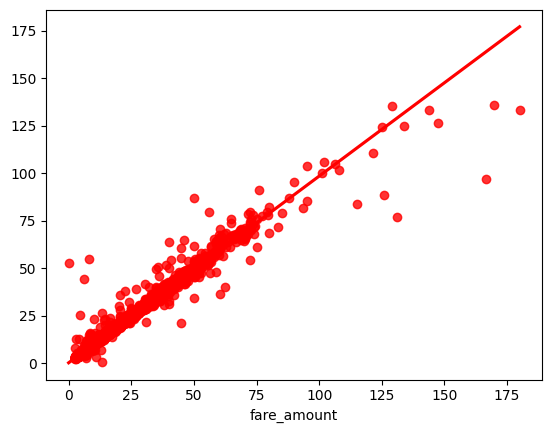

In [37]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

### Difference between Actual vs Predicted Values

In [38]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
94868,19.0,18.880274,0.119726
101360,9.5,9.568123,-0.068123
63892,6.0,5.686279,0.313721
23882,14.5,14.587996,-0.087996
9481,25.5,25.252775,0.247225
...,...,...,...
73791,8.5,8.283846,0.216154
50628,13.0,12.528666,0.471334
78979,7.0,6.705533,0.294467
62350,37.0,37.968133,-0.968133


## Model Explainability

Model explainability refers to the ability to understand how a model arrives at its results. This is particularly important for complex models, sometime called 'black boxes" where the internal working can be difficult to interpret.

Here are some key points about model explainability:
- Transparency and Trust: By explaining how a model makes decisions, users can build trust in its recommendations and identify potential biases.
- Improved Performance: Understanding a model's inner workings can help identify areas for improvement and fine-tuning.
- Regulatory Compliance: In certain industries, regulations may require models to be explainable, especially when the decisions have a significant impact.

There are various techniques used to achieve model explainability, depending on the specific model and desired level of detail. Some common approaches include:

- Feature Importance: This technique highlights which input features have the most significant influence on the model's output.
- Partial Dependence Plots (PDP): These plots visualize the marginal effect of individual features on the model's predictions.
- SHapley Additive exPlanations (SHAP): This method assigns an attribution value to each feature, explaining how much it contributes to a specific prediction.

### Feature Importance
- This technique highlights which features have the most significant influence on the model's output

In [43]:
dataset_1.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'trip_duration', 'pickup_day_no', 'dropoff_day_no',
       'pickup_hour', 'dropoff_hour', 'pickup_month', 'dropoff_month',
       'pickup_year', 'dropoff_year'],
      dtype='object')

In [44]:
features = ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
        'trip_duration', 'pickup_day_no', 'dropoff_day_no',
       'pickup_hour', 'dropoff_hour', 'pickup_month', 'dropoff_month',
       'pickup_year', 'dropoff_year']

In [45]:
importances = cat_model.feature_importances_

# Print the importances for each feature
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.4f}")

VendorID: 0.0000
passenger_count: 0.0000
trip_distance: 0.3566
RatecodeID: 0.1801
store_and_fwd_flag: 45.6826
PULocationID: 19.2873
DOLocationID: 0.8900
payment_type: 3.1141
trip_duration: 0.2735
pickup_day_no: 28.3262
dropoff_day_no: 0.1808
pickup_hour: 0.4731
dropoff_hour: 0.5718
pickup_month: 0.3410
dropoff_month: 0.1699
pickup_year: 0.1531
dropoff_year: 0.0000


In [47]:
#Creating a dataframe with feature importance ranking
pd.DataFrame(list(zip(features, importances)), columns=['Feature', 'Importance']).sort_values(by=["Importance"],ascending=False)

,Feature,Importance
4,store_and_fwd_flag,45.682559
9,pickup_day_no,28.326213
5,PULocationID,19.287291
7,payment_type,3.114114
6,DOLocationID,0.890000
12,dropoff_hour,0.571754
11,pickup_hour,0.473117
2,trip_distance,0.356554
13,pickup_month,0.340956
8,trip_duration,0.273454


### SHAP (SHapley Additive exPlanations)

This is a technique used for model explainability, particularly for complex models like tree-based ensembles (random forests, XGBoost). It goes beyond feature importance by attributing a specific contribution to each feature for every prediction the model makes.

SHAP leverages cooperative game theory, where each feature is like a player in a game. It calculates how much each feature contributes to the difference between the actual model prediction and the prediction made by a baseline model (e.g., predicting everyone gets approved or rejected).

Benefits of SHAP Analysis:

- Detailed Feature Contribution: Explains how each feature influences individual predictions, not just overall importance.
- Model Debugging: Helps identify potential biases or unexpected feature interactions in the model.
- Improved Feature Selection: Guides decisions on which features to keep or remove for better model performance.

Limitations:

- Computationally Expensive: Calculating SHAP values can be resource-intensive, especially for large datasets.
- Interpretability: While offering more detail than feature importance, SHAP can still be complex to interpret for beginners.

In [56]:
#creating SHAP explainer
import shap
#Fits the explainer using the catboost regressor model
explainer = shap.Explainer(cat_model.predict,X_test)

In [57]:
#Calculating SHAP values
shap_values = explainer(X_test)

PermutationExplainer explainer: 22451it [2:28:01,  2.52it/s]                             


In [59]:
shap_values

.values =
array([[ 0.        ,  0.        , -0.02021108, ..., -0.00458099,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.02312454, ...,  0.00764397,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.01884706, ...,  0.00743175,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.02259809, ..., -0.02168808,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.00202401, ...,  0.04912639,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.02234892, ..., -0.00617919,
         0.        ,  0.        ]])

.base_values =
array([12.94888397, 12.94888397, 12.94888397, ..., 12.94888397,
       12.94888397, 12.94888397])

.data =
array([[ 1.        ,  0.        ,  0.90579638, ..., -0.40833909,
         0.        , -0.00667424],
       [ 1.        ,  0.        , -1.10400088, ..., -0.11997672,
         0.        , -0.00667424],
       [ 1.        ,  0.        , -1.10400088, ..., -1

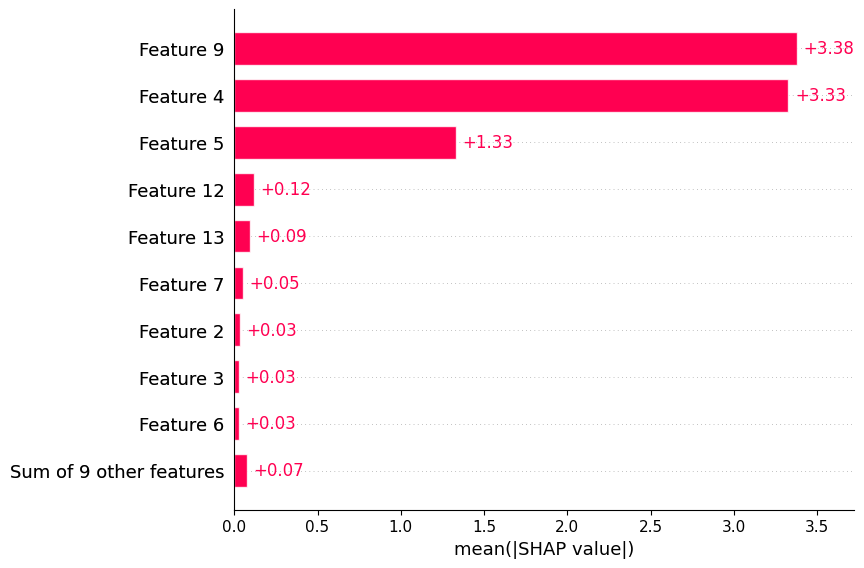

In [60]:
shap.plots.bar(shap_values)

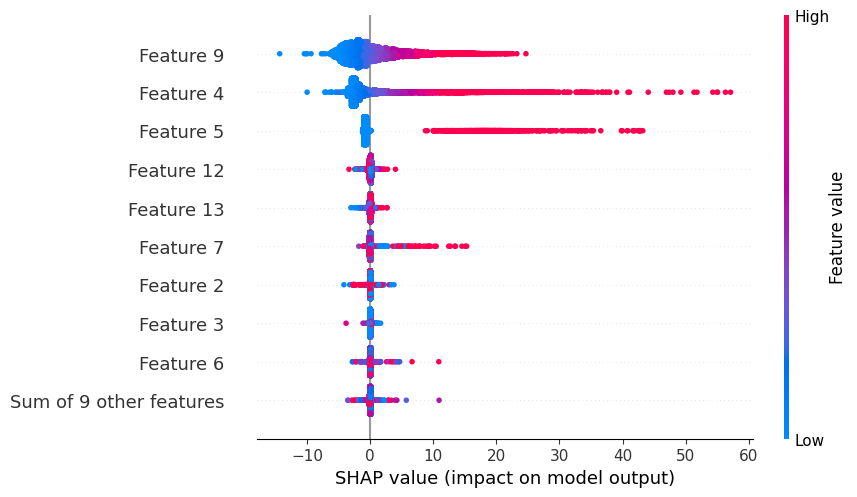

In [61]:
shap.plots.beeswarm(shap_values)

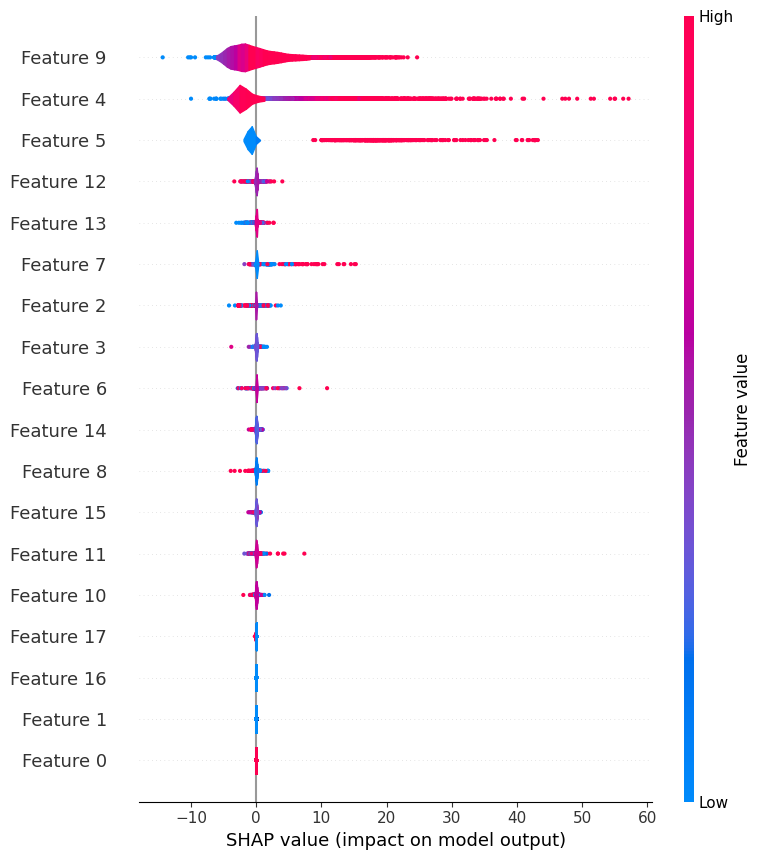

In [62]:
shap.summary_plot(shap_values, plot_type='violin')

In [64]:
dataset_1.shape

(112250, 18)

In [63]:
dataset_1.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'trip_duration', 'pickup_day_no', 'dropoff_day_no',
       'pickup_hour', 'dropoff_hour', 'pickup_month', 'dropoff_month',
       'pickup_year', 'dropoff_year'],
      dtype='object')